## Imports

In [17]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict

## Match the domainsand targets

In [40]:
file_path = '../data/taxonomy.xlsx'
taxonomy_df = pd.read_excel(file_path)

taxonomy_df.head()

,Domains,Targets
0,Nursing and Care,RemoveBlackheadsWithGlue
1,Nursing and Care,WashHair
2,Nursing and Care,ShaveBeard
3,Nursing and Care,WearContactLenses
4,Nursing and Care,UseEarplugs


In [43]:
target_to_domain = dict(zip(taxonomy_df['Targets'], taxonomy_df['Domains']))
len(target_to_domain)

180

In [46]:
with open('../data/COIN.json', 'r') as f:
    coin_json = json.load(f)

In [47]:
recipe_domains = set()
for video in coin_json['database'].values():
    domain = target_to_domain[video['class']]
    video['domain'] = domain
    recipe_domains.add(domain)

In [50]:
with open("../data/COIN_w_domains.json", 'w') as f:
    json.dump(coin_json, f)

In [51]:
coin_json['database']

{'xZecGPPhbHE': {'recipe_type': 122,
  'annotation': [{'id': '325',
    'segment': [25.0, 30.0],
    'label': 'pull up the hair to reserve place for the hair extensions'},
   {'id': '326',
    'segment': [31.0, 49.0],
    'label': 'put on the hair extensions'},
   {'id': '327',
    'segment': [107.0, 117.0],
    'label': 'put down the hair and comb'}],
  'video_url': 'https://www.youtube.com/embed/xZecGPPhbHE',
  'start': 19.621378525393986,
  'end': 134.36378671172514,
  'duration': 185.085,
  'class': 'PutOnHairExtensions',
  'subset': 'testing',
  'domain': 'Nursing and Care'},
 'NLy71UrHElw': {'recipe_type': 116,
  'annotation': [{'id': '373',
    'segment': [21.0, 22.0],
    'label': 'begin to run up'},
   {'id': '374', 'segment': [23.0, 24.0], 'label': 'begin to jump up'},
   {'id': '375', 'segment': [25.0, 26.0], 'label': 'fall to the ground'}],
  'video_url': 'https://www.youtube.com/embed/NLy71UrHElw',
  'start': 20.407162179718902,
  'end': 26.795,
  'duration': 26.795,
  'cl

## Data analysis

In [99]:
with open('../data/COIN_w_domains.json', 'r') as f:
    coin_json = json.load(f)['database']

In [43]:
subset_domain_counts = defaultdict(lambda: defaultdict(int))
domain_subset_class_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for video_id, video_info in coin_json.items():
    domain = video_info['domain']
    video_class = video_info['class']
    subset = video_info['subset']

    # Считаем количество доменов для каждого subset
    subset_domain_counts[subset][domain] += 1

    # Считаем количество классов внутри каждого домена для каждого subset
    domain_subset_class_counts[domain][subset][video_class] += 1

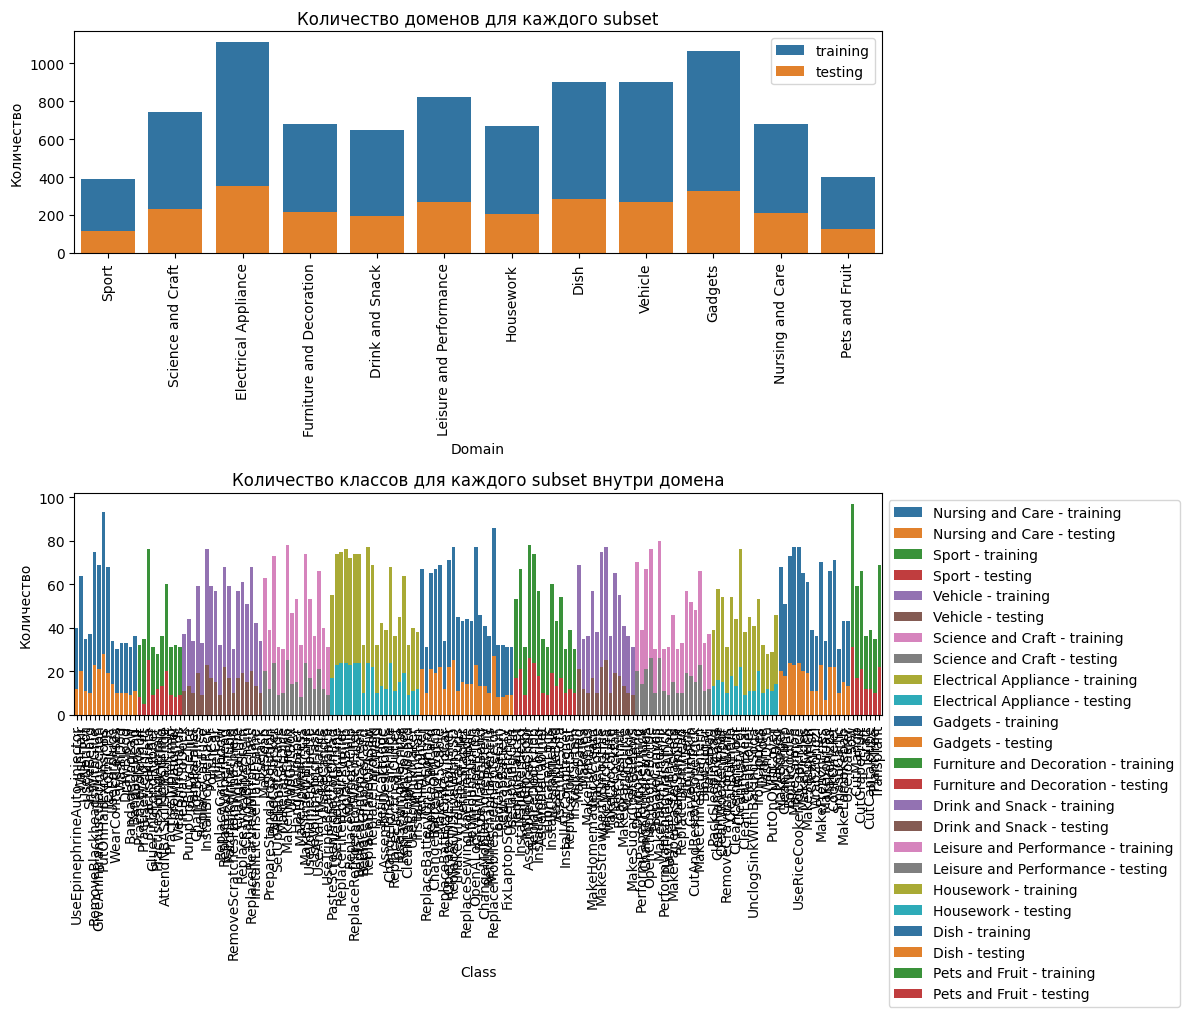

In [50]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# 1) Количество доменов для каждого subset
for subset in ['training', 'testing']:
    domain_counts = subset_domain_counts[subset]
    sns.barplot(x=list(domain_counts.keys()), y=list(domain_counts.values()), ax=axes[0], label=subset)
axes[0].set_title("Количество доменов для каждого subset")
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xlabel("Domain")
axes[0].set_ylabel("Количество")
axes[0].legend()

# 2) Количество классов для subset внутри каждого домена
for domain, subset_info in domain_subset_class_counts.items():
    for subset in ['training', 'testing']:
        class_counts = subset_info[subset]
        sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), ax=axes[1], label=f"{domain} - {subset}")
axes[1].set_title("Количество классов для каждого subset внутри домена")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Количество")
axes[1].tick_params(axis='x', rotation=90)
axes[1].legend(bbox_to_anchor=(1, 1), loc='best')

plt.tight_layout()
plt.show()

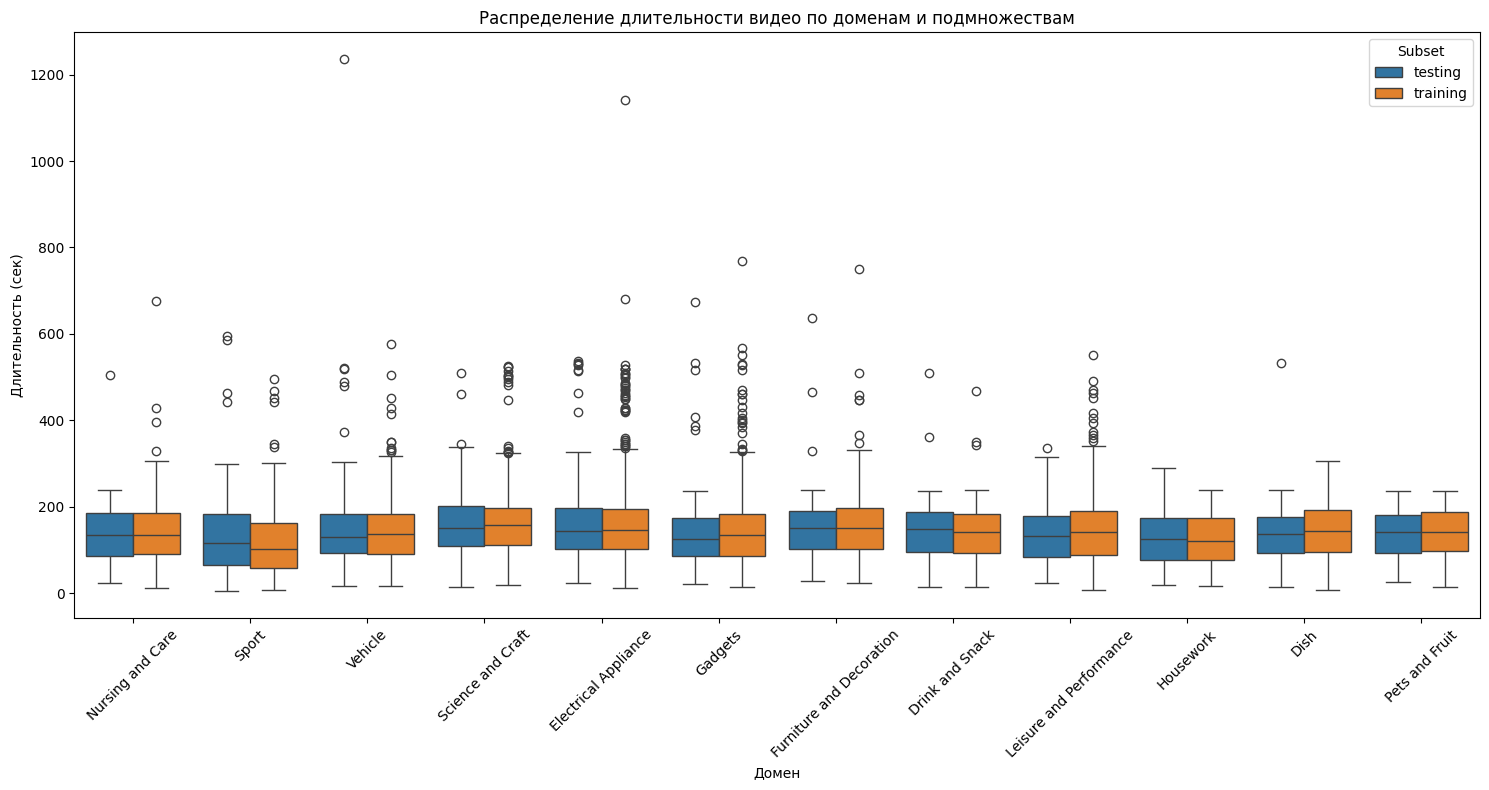

In [54]:
duration_data = []

for video_id, video_info in coin_json.items():
    domain = video_info['domain']
    subset = video_info['subset']
    duration = video_info['duration']

    # Собираем данные для boxplot
    duration_data.append({'domain': domain, 'subset': subset, 'duration': duration})

# Преобразовываем в DataFrame
duration_df = pd.DataFrame(duration_data)

# Создание фигуры для визуализации
plt.figure(figsize=(15, 8))

# Визуализация boxplot
sns.boxplot(x='domain', y='duration', hue='subset', data=duration_df)
plt.xticks(rotation=45)
plt.title("Распределение длительности видео по доменам и подмножествам")
plt.xlabel("Домен")
plt.ylabel("Длительность (сек)")
plt.legend(title='Subset')

plt.tight_layout()
plt.show()


## Filtering

- Оставим видео не более 3,5 минут

In [100]:
filtered_coin_json = {'database': {video_id: video_info for video_id, video_info in coin_json.items() if (video_info['duration'] <= 60) and (video_info['duration'] > 3)}}
with open('../data/filtered_COIN.json', 'w') as f:
    json.dump(filtered_coin_json, f, ensure_ascii=False, indent=2)

In [101]:
subset_domain_counts = defaultdict(lambda: defaultdict(int))
domain_subset_class_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for video_id, video_info in filtered_coin_json['database'].items():
    domain = video_info['domain']
    video_class = video_info['class']
    subset = video_info['subset']

    # Считаем количество доменов для каждого subset
    subset_domain_counts[subset][domain] += 1

    # Считаем количество классов внутри каждого домена для каждого subset
    domain_subset_class_counts[domain][subset][video_class] += 1

In [102]:
train_count = sum([c for c in subset_domain_counts['training'].values()])
test_count = sum([c for c in subset_domain_counts['testing'].values()])
train_count, test_count

(912, 293)

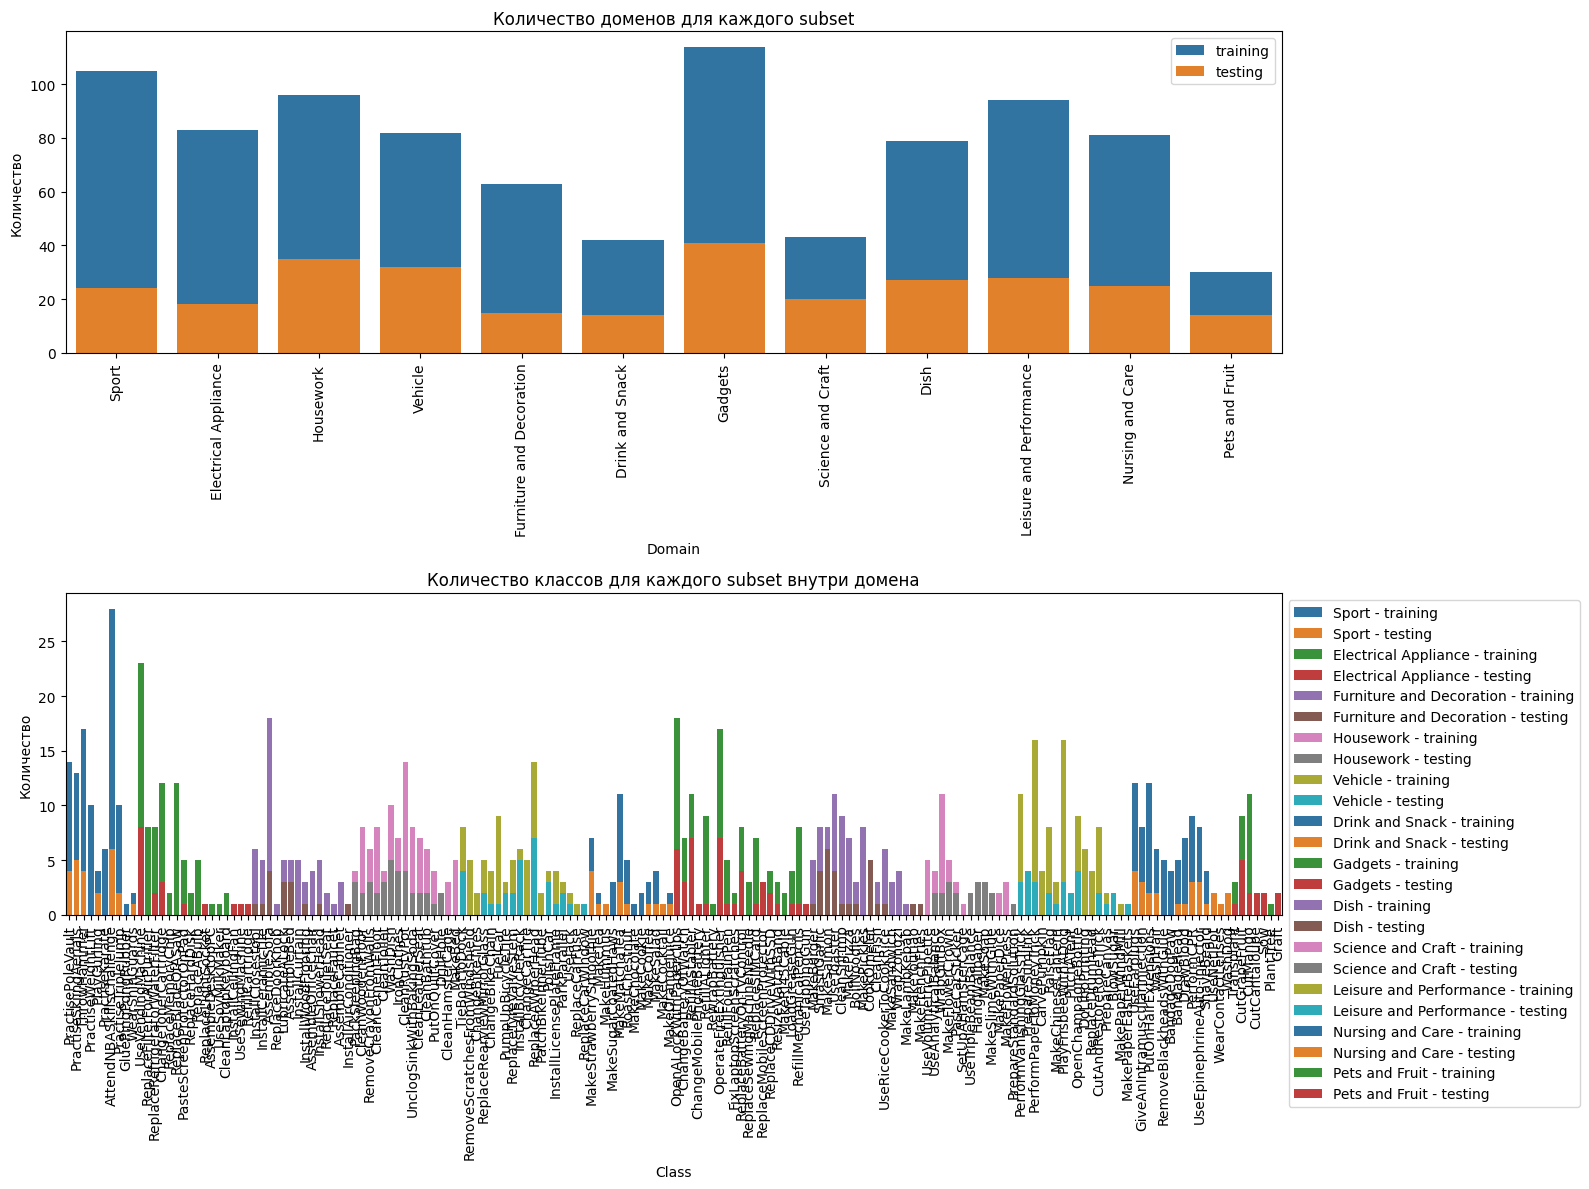

In [103]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# 1) Количество доменов для каждого subset
for subset in ['training', 'testing']:
    domain_counts = subset_domain_counts[subset]
    sns.barplot(x=list(domain_counts.keys()), y=list(domain_counts.values()), ax=axes[0], label=subset)
axes[0].set_title("Количество доменов для каждого subset")
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_xlabel("Domain")
axes[0].set_ylabel("Количество")
axes[0].legend()

# 2) Количество классов для subset внутри каждого домена
for domain, subset_info in domain_subset_class_counts.items():
    for subset in ['training', 'testing']:
        class_counts = subset_info[subset]
        sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), ax=axes[1], label=f"{domain} - {subset}")
axes[1].set_title("Количество классов для каждого subset внутри домена")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Количество")
axes[1].tick_params(axis='x', rotation=90)
axes[1].legend(bbox_to_anchor=(1, 1), loc='best')

plt.tight_layout()
plt.show()

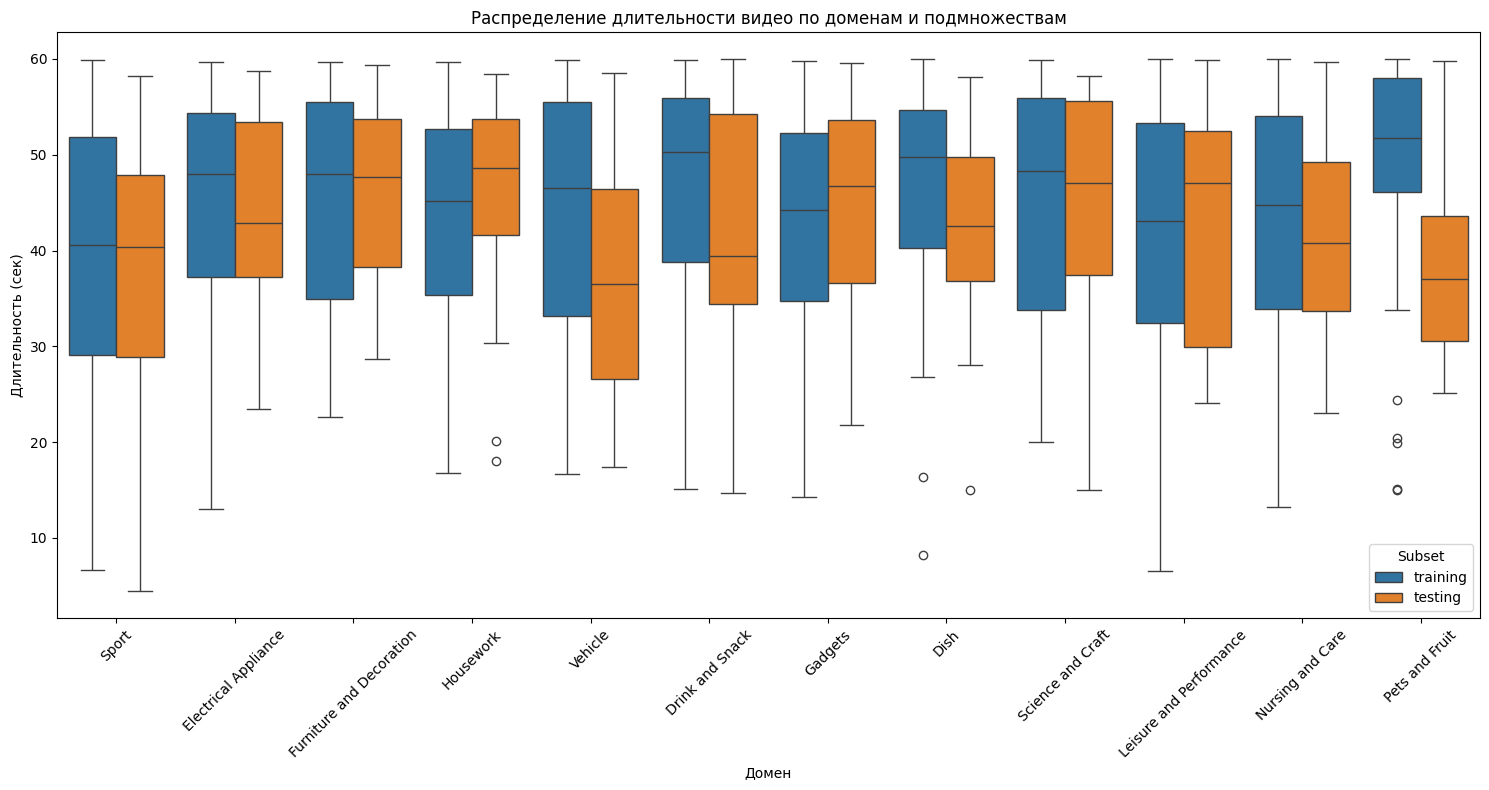

In [104]:
duration_data = []

for video_id, video_info in filtered_coin_json["database"].items():
    domain = video_info['domain']
    subset = video_info['subset']
    duration = video_info['duration']

    # Собираем данные для boxplot
    duration_data.append({'domain': domain, 'subset': subset, 'duration': duration})

# Преобразовываем в DataFrame
duration_df = pd.DataFrame(duration_data)

# Создание фигуры для визуализации
plt.figure(figsize=(15, 8))

# Визуализация boxplot
sns.boxplot(x='domain', y='duration', hue='subset', data=duration_df)
plt.xticks(rotation=45)
plt.title("Распределение длительности видео по доменам и подмножествам")
plt.xlabel("Домен")
plt.ylabel("Длительность (сек)")
plt.legend(title='Subset')

plt.tight_layout()
plt.show()
